# May the Best Woman Win! 

We're looking to build our model using imdb movie reviews. I used movie reviews because I found this to be the corpus that most resembles the type of data I'm working with. Source: https://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
# Importing our libraries
from sklearn.datasets import load_files
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing the data
reviews_train = load_files("train")

In [3]:
df = pd.DataFrame(data=[reviews_train.data, reviews_train.target]).transpose()
df.columns = ['text_train', 'y_train']

Let's take a look at our DataFrame so far

In [4]:
df.head()

,text_train,y_train
0,b'Full of (then) unknown actors TSF is a great...,2
1,"b""Amount of disappointment I am getting these ...",2
2,"b'The future, we are told, are what we make of...",2
3,"b""Dan Katzir has produced a wonderful film tha...",1
4,b'If you want Scream or anything like the big-...,1


In [5]:
# There's data as well for unsupervised learning, which we don't need for this exercise
df.drop(df[df.y_train == 2].index, axis=0, inplace=True)

In [6]:
df.dtypes

text_train    object
y_train       object
dtype: object

In [7]:
df.y_train = df.y_train.astype('int')

In [8]:
# Doing some cleaning 
df.text_train = [doc.replace(b'<br />', b' ') for doc in df.text_train]

### Building Our Model

So now that we've created our dataframe, its time to follow through with the transformation process. I'm using the TfidVectorizer to create my sparse matrix. One could use the CountVectorizer as well - however, this is a word count only. 

Additionally:
- **min_df = 5**: excludes terms that have been used less than 5 times in the documents
- **stop_words='english'**: excludes stopwords 

In [9]:
pipe = Pipeline([('tfid',TfidfVectorizer(min_df=5, stop_words='english')), ('logreg', LogisticRegression())])
param_grid = {'logreg__C': [10], 'tfid__ngram_range':[(1,2)]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(df.text_train, df.y_train)

C:\Users\m_abolhallaj\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\m_abolhallaj\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfid',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                                        no

In [10]:
# Cross validation score
grid.best_score_

0.89584

#### Now that we have built our model, its time to apply it to our data!

In [11]:
# episodes is a separate .py file that contains the Reddit API instance, along with the indexes of the pages that contain 
# the Untucked! comments
import episodes

In [12]:
comments_dict = {
    'comment_id': [],
    'comment' : [],
    'Upvotes_Comment' : [],
    'author' : [],
    'episodeNumber':[]
    }
reddit = episodes.reddit

for epi in episodes.episodes:
    submission = reddit.submission(id=epi)
    submission.comments.replace_more(limit=None)
    for h in submission.comments:
        comments_dict['comment_id'].append(h.id)
        comments_dict['comment'].append(h.body)
        comments_dict['Upvotes_Comment'].append(h.ups)
        comments_dict['author'].append(h.author)
        comments_dict['episodeNumber'].append(episodes.episodes.index(epi) + 1)
queen_comments = pd.DataFrame(comments_dict)

In [13]:
queen_comments.head()

,comment_id,comment,Upvotes_Comment,author,episodeNumber
0,fj2isah,so all these queens complimenting each other i...,347,Homosuxual,1
1,fj2hlgg,Heidi slurped that drink down and got sad drun...,341,disfluency,1
2,fj2j6cl,dam nicki’s critique of heidi’s makeup was act...,327,wwmhd,1
3,fj2ipw8,"Crystal, dressed as HIM...""I'm a quiet person""",313,MrSwearword,1
4,fj2hmxi,Nicky is reminding me of Sofia Vergara’s chara...,296,fuckyourcousinsheila,1


In [14]:
queen_comments.episodeNumber.value_counts()
# Episode 5 was quite fiery

5    1105
6     790
7     671
8     466
9     389
4     309
3     273
1     226
2     160
Name: episodeNumber, dtype: int64

In [15]:
# some cleaning
queen_comments.comment = [x.replace('\n', " ") for x in queen_comments.comment]

In [16]:
# Applying our model
queen_comments['model_predicted'] = grid.predict(queen_comments.comment)

## Doing an analysis on the queens 

This dataframe will be used to identify which queens are mentioned in what comment

- It is assumed the comment is about a queen if their name is mentioned in the comments
- This also applied if multiple queens' names are mentioned 

In [17]:
queens = {'aiden': [], 'sherry': [], 'brita': [], 'heidi': [], 'gigi': [], 'jackie': [], 'widow': [], 'nicky': [], 'crystal': [], 'jaida': [], 'rock m': [], 'dahlia': [], 'jan': []}
for queen in queens:
    for comment in queen_comments.comment:
        if queen in comment.lower() or  queen+"'s" in comment.lower() or queen+"s"in comment.lower(): 
            queens[queen].append(queen)
        else:
            queens[queen].append(0)
#queens_copy = pd.DataFrame(queens_copy)

queens = pd.DataFrame(queens)

grouped = []
def groupy(a):
    return list(filter(lambda a: a != 0, a))
for i in queens.iterrows():
        grouped.append(groupy(i[1].to_list()))

In [18]:
queens.head()

,aiden,sherry,brita,heidi,gigi,jackie,widow,nicky,crystal,jaida,rock m,dahlia,jan
0,0,0,brita,0,0,0,0,0,0,0,0,0,0
1,0,0,0,heidi,0,0,0,0,0,0,0,0,0
2,0,0,0,heidi,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,crystal,0,0,0,0
4,0,0,0,0,0,0,0,nicky,0,0,0,0,0


In [20]:
queen_comments['grouped'] = grouped 

In [21]:
queen_comments.head()

,comment_id,comment,Upvotes_Comment,author,episodeNumber,model_predicted,grouped
0,fj2isah,so all these queens complimenting each other i...,347,Homosuxual,1,1,[brita]
1,fj2hlgg,Heidi slurped that drink down and got sad drun...,341,disfluency,1,0,[heidi]
2,fj2j6cl,dam nicki’s critique of heidi’s makeup was act...,327,wwmhd,1,0,[heidi]
3,fj2ipw8,"Crystal, dressed as HIM...""I'm a quiet person""",313,MrSwearword,1,1,[crystal]
4,fj2hmxi,Nicky is reminding me of Sofia Vergara’s chara...,296,fuckyourcousinsheila,1,1,[nicky]


To make it easier to handle plotting and groupbys, I created a separate column in queen_comments that is just the string.

In [22]:
queen_comments['stringed'] = [', '.join(q) for q in queen_comments.grouped]

### A bit of exploratory data analysis 
Let's look at the frequence queens are mentioned

Text(0.5, 1.0, 'Mentions per Queen (#)')

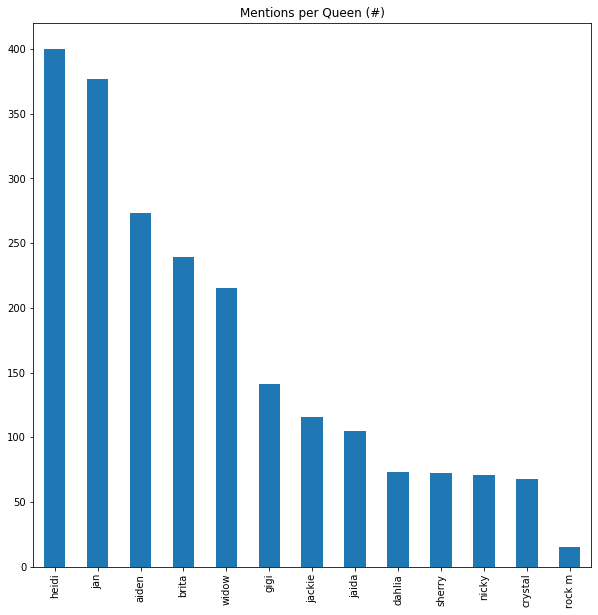

In [23]:
queen_comments.stringed[queen_comments.grouped.apply(lambda x: len(x)==1)].value_counts().plot(kind='bar', figsize=(10,10))
plt.title('Mentions per Queen (#)')

Which queens appeared together?

Text(0.5, 1.0, 'Mentions per Queen Pair (#)')

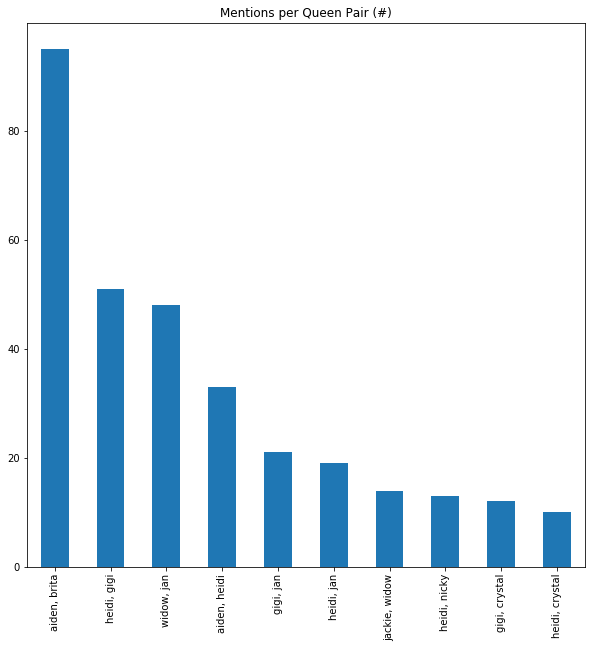

In [24]:
queen_comments.stringed[queen_comments.grouped.apply(lambda x: len(x)==2)].value_counts().head(10).plot(kind='bar', figsize=(10,10))
plt.title('Mentions per Queen Pair (#)')

Which queen seems to be involved with everyone?

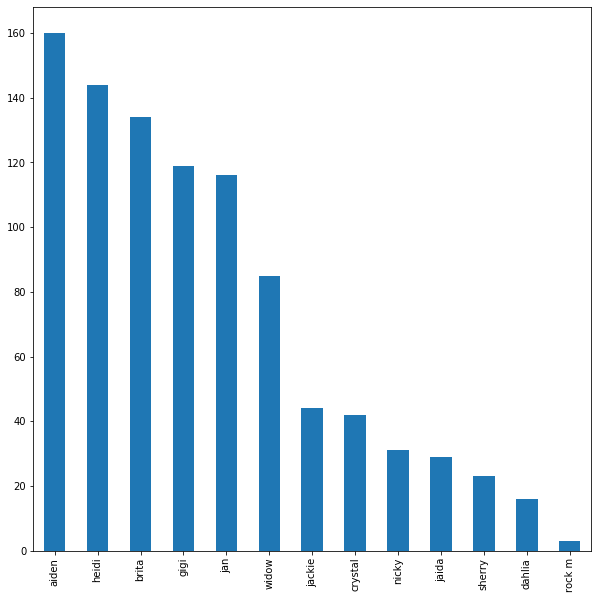

In [25]:
flattened = pd.Series(sum(queen_comments.grouped[queen_comments.grouped.apply(lambda x: len(x)==2)], []))
flattened.value_counts().plot(kind='bar', figsize=(10,10))

### Let's look at the sentiment of the comments

Grouped per episode and queen

In [26]:
pos = queen_comments[['episodeNumber','stringed', 'model_predicted']].groupby(['stringed', 'episodeNumber']).sum()
tot = queen_comments[['episodeNumber','stringed', 'model_predicted']].groupby(['stringed', 'episodeNumber']).count()
neg = tot - pos

In [27]:
df_sent = pd.concat([pos, neg, tot], axis=1)
df_sent.columns = ['Positive', 'Negative', 'Total']
df_sent.drop(index='', level=0, axis=0, inplace=True)

In [28]:
df_sent.head(10)

Positive  Negative  Total
stringed     episodeNumber                           
aiden        2                     1         4      5
             3                     5        12     17
             4                    15        30     45
             5                    41       121    162
             6                    12        30     42
             8                     1         0      1
             9                     1         0      1
aiden, brita 4                     1         1      2
             5                    22        48     70
             6                     6        12     18

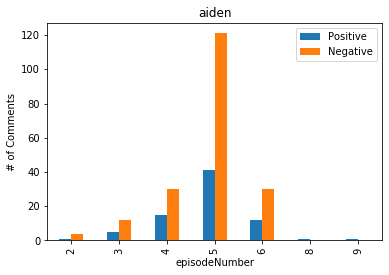

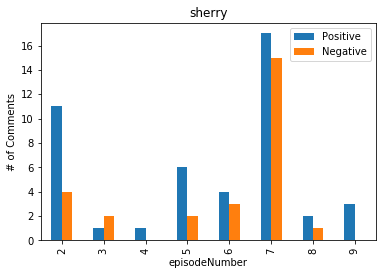

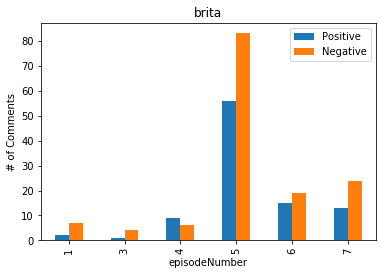

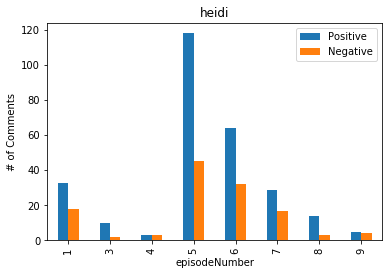

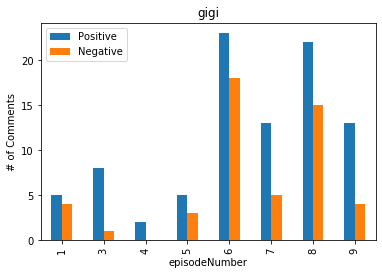

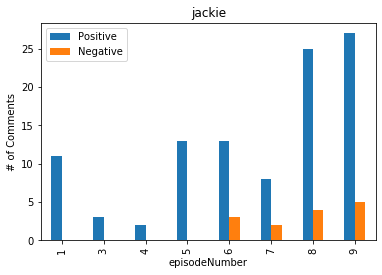

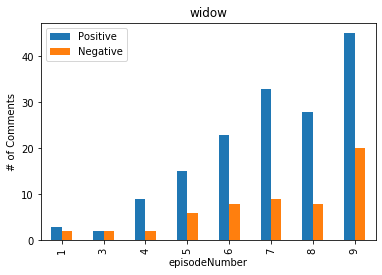

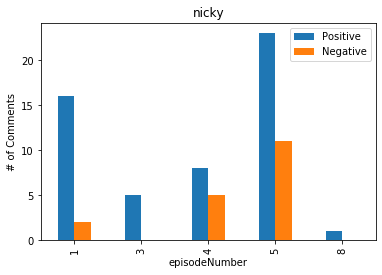

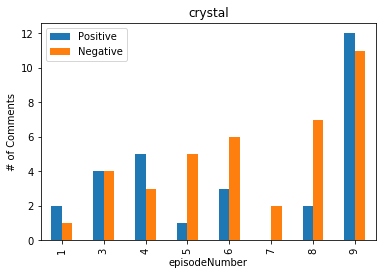

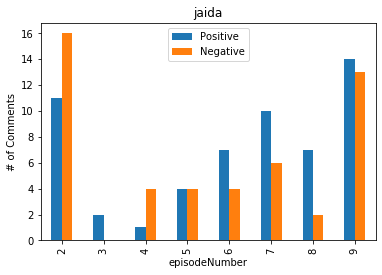

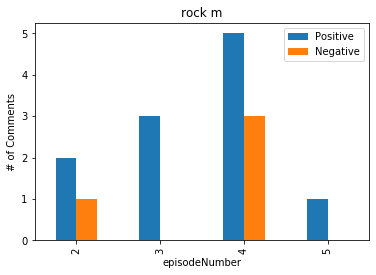

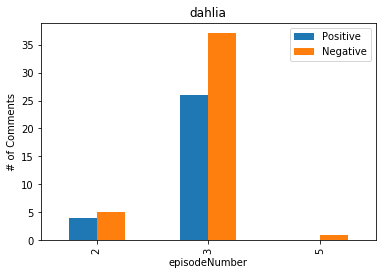

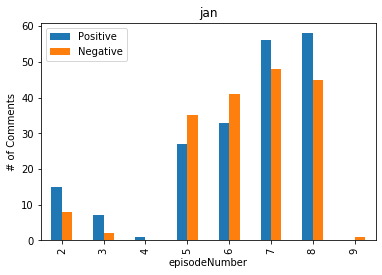

In [29]:
df_single = df_sent.loc[[',' not in x[0] for x in df_sent.index]] # Queens by themselves
for q in queens.columns:
    df_single.xs(q)[['Positive','Negative']].plot(kind='bar')
    plt.title(q)
    plt.ylabel('# of Comments')


### Mean + / - sentiment per Queen

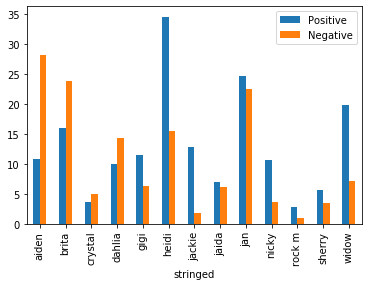

In [36]:
df_single.reset_index().groupby('stringed').mean()[['Positive','Negative']].plot(kind='bar')
# Heidi has the most positive sentiments 

### Let's look at the sentiment when queens are mentioned together

In [31]:
df_deux = queen_comments[queen_comments.grouped.apply(lambda x: len(x)==2)] # Queens that appeared together
pos = df_deux[['episodeNumber','stringed', 'model_predicted']].groupby(['stringed', 'episodeNumber']).sum()
tot = df_deux[['episodeNumber','stringed', 'model_predicted']].groupby(['stringed', 'episodeNumber']).count()
neg = tot - pos

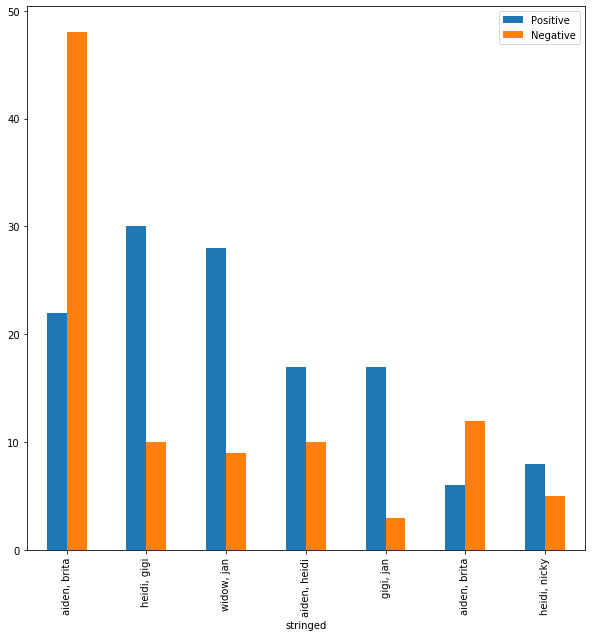

In [32]:
df_deux_sent = pd.concat([pos, neg, tot], axis=1)
df_deux_sent.columns = ['Positive', 'Negative', 'Total']
df_deux_sent.reset_index(level=1).sort_values(by='Total', ascending=False).head(7)[['Positive', 'Negative']].plot(kind='bar', figsize=(10,10))

### Taking a look at the comments coming in

In [33]:
queen_comments[queen_comments.model_predicted == 0]['comment'].sample(10) #Looking only at model predicted negative comments

3972                                     Jan got elf ears
1736                          Gigi looks fucking correct.
118     The main episode has been up on wow+ for hours...
2648                                  So many commercials
2459                           Sherry speaking facts, oop
441     cannot stand Brita. conceited, arrogant and nosy.
2938              I’m sorry how the fuck did Jan not win?
3673    You can tell crystal is bummed about saying wi...
3484    Stop trying to make “You Brita Work” happen, i...
3628    I just wanna celebrate my flair. My girl did it 😭
Name: comment, dtype: object

In [34]:
queen_comments[queen_comments.model_predicted == 1]['comment'].sample(10) #looking only at model predicted positive comments

3563    Heidi: "You bitch you won like 12 challenges.....
1168    NOBODY CARES ABOUT YOUR PARTICIPATION TROPHIES...
1572                            Heidi is my literal queen
3824        Widow is so cute omg Chaka really is her idol
2181                         Heidi's note is so sweet omg
1310                      This are Phi Phi levels of salt
68                           gooped ->goupé (en français)
4096    The Canadian being the most outspoken and educ...
256              Rock we are all already in love with you
3981                                           Lol jk Jan
Name: comment, dtype: object

As we can see, the model application doesn't show the true sentiment of the comments at times. It has been trained to detect words that (when used in movie reviews) could have negative words. Words like "Love", "Well", etc. are more likely to be classified as having a positive sentiment

# Thank you, please leave a review & share 